# data load

In [7]:
import tarfile
from scipy.io import arff
import numpy as np
import pandas as pd


# 압축해제
path = "../data"
aloi_tar = tarfile.open(path+"/PageBlocks.tar.gz")
aloi_tar.extractall(path+"/PageBlocks")
aloi_tar.close()

# data load
PB = arff.loadarff(path + "/PageBlocks/PageBlocks/PageBlocks_withoutdupl_norm_09.arff")
PB = pd.DataFrame(PB[0])

* att1 ~ 10의 설명변수와 index를 나타내는 id, 이상치 여부인 outlier로 구성

In [9]:
PB.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,id,outlier
0,0.004981,0.010870,0.000194,0.002594,0.367089,0.634328,0.000268,0.000212,0.000347,0.001557,1.0,b'no'
1,0.006227,0.010870,0.000243,0.002160,0.397679,0.873134,0.000525,0.000333,0.000650,0.001246,2.0,b'no'
2,0.006227,0.030797,0.000701,0.005574,0.247890,0.723881,0.000692,0.000727,0.001583,0.001869,3.0,b'no'
3,0.004981,0.010870,0.000194,0.002594,0.336498,0.726013,0.000672,0.000182,0.000412,0.000623,4.0,b'no'
4,0.006227,0.003623,0.000076,0.000918,0.472574,0.940299,0.000252,0.000061,0.000217,0.000934,5.0,b'no'


In [10]:
PB.index =PB['id'].astype(int)
set_a = PB['outlier'] == b'yes'  # outlier 변수가 b'yes'인 값
set_b = PB['outlier'] == b'no'
PB.loc[set_a, 'target'] = 1
PB.loc[set_b, 'target'] = 0
PB.loc[:, 'target'] = PB['target'].astype(int)
PB = PB.drop(['outlier', 'id'], axis=1)

In [11]:
PB.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,target
id,,,,,,,,,,,
1,0.004981,0.010870,0.000194,0.002594,0.367089,0.634328,0.000268,0.000212,0.000347,0.001557,0
2,0.006227,0.010870,0.000243,0.002160,0.397679,0.873134,0.000525,0.000333,0.000650,0.001246,0
3,0.006227,0.030797,0.000701,0.005574,0.247890,0.723881,0.000692,0.000727,0.001583,0.001869,0
4,0.004981,0.010870,0.000194,0.002594,0.336498,0.726013,0.000672,0.000182,0.000412,0.000623,0
5,0.006227,0.003623,0.000076,0.000918,0.472574,0.940299,0.000252,0.000061,0.000217,0.000934,0


# preprocessing

In [23]:
import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split

raw_X = PB.drop("target", axis=1)
raw_Y = PB["target"]

col_ = raw_X.columns
stand_X_scaler = pp.StandardScaler()
stand_X = stand_X_scaler.fit_transform(raw_X)
stand_X = pd.DataFrame(data=stand_X, index=raw_X.index, columns=raw_X.columns)
scaling_param = pd.DataFrame(data=[stand_X_scaler.mean_, stand_X_scaler.scale_], index=['mean', 'std'], columns=col_)  # 표준화에 사용된 평균, 표준편차

X_train, X_test, Y_train, Y_test = train_test_split(stand_X, raw_Y, test_size=0.33, random_state=314, shuffle=True, stratify=raw_Y)

In [25]:
# visualizing

import matplotlib.pyplot as plt
import seaborn as sns

def mean_for_each_target(df_X, df_Y, plot_=False, return_=False):
    df_mean = df_X.mean().reset_index()  # 전체 x의 평균
    df_mean.columns = ['field', 'mean']
    df_mean['target'] = 'total'
    mean_ = df_mean['mean']

    # 타겟별 x값의 평균
    for each in df_Y.unique():
        set_ = df_Y == each
        set_df_X = df_X[set_]
        set_df_X = set_df_X.mean().reset_index()
        set_df_X.columns = ['field', 'mean']
        set_df_X['target'] = each
        df_mean = pd.concat((df_mean, set_df_X), axis=0).reset_index(drop=True)

    df_mean_t = pd.DataFrame({})
    for each in df_mean['target'].unique():
        set_ = df_mean['target'] == each
        v_set = df_mean[set_]['mean'].reset_index(drop=True)
        v_set.name = each
        df_mean_t = pd.concat((df_mean_t, v_set), axis=1)

    df_mean_t = df_mean_t.T
    df_mean_t.columns = df_X.columns
    df_mean_t

    if plot_:
        sns.catplot(x='field', y='mean', hue='target', kind='bar', data=df_mean, height=5, aspect=2)
        plt.title('mean for each target')
        plt.figure(figsize=(20, 10))
        plt.show()

    if return_:
        return df_mean, df_mean_t

* y값에 따른 x값의 분포 시각화 결과, 이상치일때와 그렇지 않을때의 x값의 분포가 매우 다른것을 확인할 수 있음

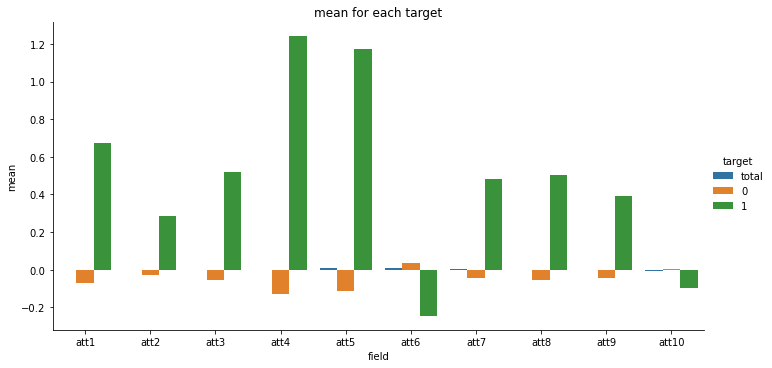

<Figure size 1440x720 with 0 Axes>

In [26]:
mean_for_each_target(X_train, Y_train, plot_=True)

In [60]:
from sklearn.decomposition import PCA

def PCA_inverse(df_X, n_components='total', svd_solver='full', whiten=False, random_state=314):
    if n_components == 'total':
        n_components = len(df_X.columns)
    else:
        n_components = n_components

    pca = PCA(n_components=n_components, random_state=random_state, svd_solver=svd_solver)

    df_X_PCA = pca.fit_transform(df_X)
    print(df_X_PCA.shape)
    print(df_X.columns)
    df_X_PCA = pd.DataFrame(data=df_X_PCA, index=df_X.index)

    df_X_PCA_inv = pca.inverse_transform(df_X_PCA)
    df_X_PCA_inv = pd.DataFrame(data=df_X_PCA_inv, index=df_X.index, columns=df_X.columns)

    return pca, df_X_PCA, df_X_PCA_inv

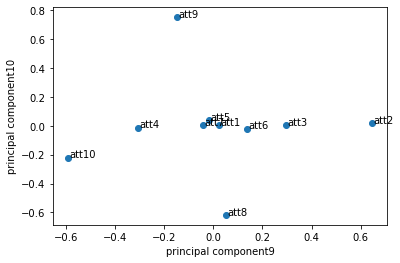

In [40]:
pca, df_X_PCA, df_X_PCA_inv = PCA_inverse(X_train)

def pca_pair(pca, columns, components=(1, 2)):
    c1 = components[0] - 1
    c2 = components[1] - 1
    plt.scatter(pca.components_[c1], pca.components_[c2])
    for i, txt in enumerate(X_train.columns):
        plt.annotate(txt, (pca.components_[c1][i]+0.005, pca.components_[c2][i]+0.001))

    plt.xlabel('principal component'+str(c1+1))
    plt.ylabel('principal component'+str(c2+1))
    plt.show()

pca_pair(pca, X_train.columns, components=(9, 10))

* 마지막 두 주성분의 분산 방향 시각화 결과, 십자 형태로 상관성이 떨어지는 모양이 나타남. 이는 이상치의 종류가 두가지임을 시사함

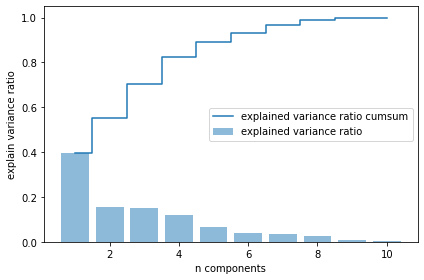

In [39]:
def pca_explained_variance(pca):
    plt.bar(range(1, len(pca.explained_variance_ratio_)+1),
            pca.explained_variance_ratio_,
            alpha=0.5,
            align='center',
            label="explained variance ratio")
    plt.step(range(1, len(pca.explained_variance_ratio_)+1),
             pca.explained_variance_ratio_.cumsum(),
             where='mid',
             label='explained variance ratio cumsum')

    plt.ylabel('explain variance ratio')
    plt.xlabel("n components")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

pca_explained_variance(pca)

* 10개 주성분의 총 합은 1이므로 1개 이상의 정보를 가지는 주성분은 0.1보다 큼
* 다섯번째부터 0.1보다 작아지고, 4번째까지의 총합이 전체 데이터의 80% 이상을 설명하므로 4번째 주성분까지 반영하는것이 좋음

In [50]:
evr_cumsum = pca.explained_variance_ratio_.cumsum()
evr_cols = np.min(np.argmin(abs(evr_cumsum - (1 - 0.1))))+1
print("최초로 분산 비율이 10% 이하인 주성분의 위치 :", evr_cols)

최초로 분산 비율이 10% 이하인 주성분의 위치 : 5


#재구축 오차

In [61]:
pca, X_train_PCA, X_train_PCA_inv = PCA_inverse(X_train, n_components=evr_cols)


(3613, 5)
Index(['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9',
       'att10'],
      dtype='object')


In [65]:
pd.DataFrame((X_train_PCA_inv.mean() - X_train.mean()).round(2), columns=['평균 변화량']).T

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10
평균 변화량,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0


In [66]:
pd.DataFrame((X_train_PCA_inv.std() - X_train.std()).round(2), columns=['표준 편차 변화량']).T

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10
표준 편차 변화량,-0.05,-0.04,-0.1,-0.04,-0.08,-0.1,-0.0,-0.07,-0.03,-0.07


* 5개의 주성분으로 복원한 결과, 평균값의 차이는 없고 표준편차가 아주 살짝 감소한것을 확인할 수 있음

In [67]:
from sklearn.covariance import EmpiricalCovariance

# 공분산행렬 계산
emp_cov = EmpiricalCovariance().fit(X_train_PCA_inv)

# 마할라노비스 거리
outlier_score = emp_cov.mahalanobis(X_train)
outlier_score = pd.Series(outlier_score, index=X_train_PCA_inv.index)

outlier_score.describe()

count    3613.000000
mean        5.000000
std        65.361312
min         0.015540
25%         0.470877
50%         0.841527
75%         1.996187
max      3498.367622
dtype: float64

* 평균이 5, 표준편차는 65로 큰 값이 나타남
* 최대값이 3498인데 75%에 해당하는 값도 1.9에 불과함
* 따라서 이상치는 정상 데이터에 비해 상당히 큰 값을 가진다고 볼 수 있으며, 이를 재구축 오차라고 부름

In [68]:
def predict_df(y_actual, y_score, threshold=50):
    binary_thread = np.percentile(y_score, threshold)

    df_preds = pd.concat((y_actual, y_score.apply(lambda x: 1 if x >= binary_thread else 0), y_score), axis=1)
    df_preds.columns = ['actual', 'predict', 'score']
    return df_preds

df_preds = predict_df(Y_train, outlier_score, 90)
df_preds.head()

,actual,predict,score
id,,,
4085,0,0,0.448178
2253,0,0,1.913160
4895,1,1,41.051048
1792,0,0,3.211341
2948,0,0,1.718232


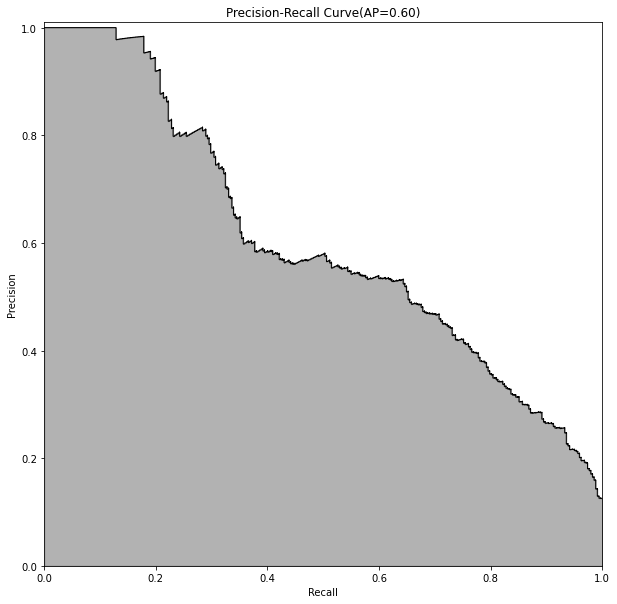

In [73]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plt_precision_recall_curve(y_actual, y_score):
    precision, recall, threshold = precision_recall_curve(y_actual, y_score)
    average_precision = average_precision_score(y_actual, y_score)
    plt.title("Precision-Recall Curve(AP={0:0.2f})".format(average_precision))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.step(recall, precision, color="k", lw=1)
    plt.fill_between(recall, precision, color="k", step="post", alpha=0.3)
    plt.show()

plt.figure(figsize=(10, 10))
plt_precision_recall_curve(df_preds['actual'], df_preds['score'])